# Variational manifold PLDA in TensorFlow


This is the modify code from (https://jmetzen.github.io/2015-11-27/vae.html).
This is come from the idea of Variational auto-encoder. 



In [ ]:
# #import tdb

import numpy as np
import math
import tensorflow as tf


import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)
import sys
#sys.path.append('/usr/lib/Python/2.7/site-packages/')

Import NIST 2014 dataset. Put NIST 2014 dataset under "./NIST_data" folder

In [2]:
import os

#check path
print(os.getcwd())
import scipy.io

import read_mat
ivec14 = read_mat.read_data_sets('NIST_data/', dtype=np.float32)

#sort with manifold solution
ivec14.train.sort()

#whitening
ivec14_W = ivec14.train.length_norm()
ivec14.train.speaker_dict()
n_samples = ivec14.train.num_examples

ivec14.test.test_length_norm(ivec14_W,ivec14.train._mean_ivec)



/home/hcwei/Tensorflow/iPython VAE/Gaussian_latent/speaker_pair_wise_manifold


Import MNIST dataset.

In [2]:
# Load MNIST data .
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples
print n_samples







Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
55000


Check NIST dataset. Demo EER function and DCF function.

In [3]:
score_mat = scipy.io.loadmat('NIST_data/'+"scores.mat")
score = score_mat['scores']
print(ivec14.test.compute_eer(score))
print(ivec14.test.compute_dcf(score))




11562621
11562622
7.97144543946
12582004
12582004
12582004
(0.53843443617709452, 0.4823136775051346)


In [3]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

Each scoring funcion

In [4]:
def PLDA_score(m,V,Sigma):
    m=m.T
    V=V.T


    nphi = np.shape(V)[0]

    Sigma_ac = np.dot(V,V.T)
    Sigma_tot = Sigma_ac + Sigma

    Sigma_tot_i = np.linalg.pinv(Sigma_tot)
    Sigma_i = np.linalg.pinv( Sigma_tot-  np.dot(np.dot(Sigma_ac, Sigma_tot_i), Sigma_ac)  )
    Q = Sigma_tot_i-Sigma_i
    P = np.dot(np.dot(Sigma_tot_i, Sigma_ac), Sigma_i)




    U, S, V = np.linalg.svd(P)


    Lambda = np.diag( S[np.arange(nphi)]  )


    Uk = U[ :, np.arange(nphi)  ]
    Q_hat = np.dot(np.dot(Uk.T , Q) ,Uk)

    
    model_iv = np.dot(Uk.T , ivec14.test._verify_data.T-m[:,None]  )
    test_iv = np.dot(Uk.T , ivec14.test._ivectors.T-m[:,None]  )


    score_h1 = np.diag( np.dot(np.dot(model_iv.T,Q_hat), model_iv ) )
    score_h2 = np.diag( np.dot(np.dot(test_iv.T ,Q_hat), test_iv  ) )



    score_h1h2 = 2* np.dot( np.dot( model_iv.T ,Lambda) ,test_iv)



    scores = np.add(score_h1h2 , score_h1[:,None])

    scores = np.add(scores , score_h2.T)
    return scores


In [5]:
def Cosine_score(z_model , z_test):
    

    z_model_norm = np.linalg.norm(z_model,ord=2,axis=1)
    z_model_data = (z_model  /z_model_norm[:,None])

    z_test_norm = np.linalg.norm(z_test,ord=2,axis=1)
    z_test_data = (z_test  /z_test_norm[:,None])

    scores = np.dot(z_model_data , z_test_data.T)
    
    return scores

In [6]:
def neg_Cosine_score(z_model , z_test):
    #z_model = vae.transform(ivec14.test._verify_data)
    #z_test = vae.transform(ivec14.test._ivectors)

    z_model_sq = np.sum(z_model*z_model,axis=1)
    z_test_sq = np.sum(z_test*z_test,axis=1)
    z_dot = np.dot(z_model,z_test.T)
    
    scores = -0.5*z_model_sq[:,None] + z_dot  - 0.5*z_test_sq[:,None].T
    
    return scores

In [96]:
def modify_PLDA_score(m,V,Sigma,xs,xt,s_mean,t_mean):
    ##modify PLDA with recover mean.
    ##xs for model i-vector ,xt for test i-vector
    ##s_mean for recover model i-vecor ,t_mean for recover test i-vecor
    ##This is modufy by myself and perform bad
    
    m=m.T
    V=V.T
    nphi = np.shape(V)[0]

    Sigma_ac = np.dot(V,V.T)
    Sigma_tot = Sigma_ac + Sigma

    Sigma_tot_i = np.linalg.pinv(Sigma_tot)
    Sigma_i = np.linalg.pinv( Sigma_tot-  np.dot(np.dot(Sigma_ac, Sigma_tot_i), Sigma_ac)  )
    Q = Sigma_tot_i-Sigma_i
    P = np.dot(np.dot(Sigma_tot_i, Sigma_ac), Sigma_i)




    U, S, V = np.linalg.svd(P)

    Lambda = np.diag( S[np.arange(nphi)]  )


    Uk = U[ :, np.arange(nphi)  ]
    Q_hat = np.dot(np.dot(Uk.T , Q) ,Uk)


    model_iv = np.dot(Uk.T , xs.T - s_mean.T )
    test_iv = np.dot(Uk.T , xt.T - t_mean.T  )


    score_h1 = np.diag( np.dot(np.dot(model_iv.T,Q_hat), model_iv ) )
    score_h2 = np.diag( np.dot(np.dot(test_iv.T ,Q_hat), test_iv  ) )

    score_h1h2 = 2* np.dot( np.dot( model_iv.T ,Lambda) ,test_iv)



    scores = np.add(score_h1h2 , score_h1[:,None])

    scores = np.add(scores , score_h2.T)

    
    return scores

In [83]:
def my_score(m,V,Sigma,xs,xt,s_mean,t_mean):
    ##Differ scoring concerning on different mean
    ##xs for model i-vector ,xt for test i-vector
    ##s_mean for recover model i-vecor ,t_mean for recover test i-vecor
    
    m=m.T
    V=V.T
    
    s_mean = s_mean.T
    t_mean = t_mean.T

    xs = xs.T
    xt = xt.T
    
    Sigma_ac = np.dot(V,V.T)
    Sigma_tot = Sigma_ac + Sigma



    Sigma_tot_i = np.linalg.pinv(Sigma_tot)
    W = np.linalg.pinv( Sigma_tot-  np.dot(np.dot(Sigma_ac, Sigma_tot_i), Sigma_ac)  )

    R = -np.dot(np.dot(Sigma_tot_i, Sigma_ac), W)


    


    score_h1 = np.diag( np.dot(np.dot(xs.T, Sigma_tot_i-W), xs ) ) \
         +np.diag( np.dot(np.dot(s_mean.T,Sigma_tot_i-0.5*W-0.5*R), s_mean ) ) \
         +np.diag( np.dot(np.dot(xs.T, W+R -2*Sigma_tot_i), s_mean ) )

    score_h2 = np.diag( np.dot(np.dot(xt.T, Sigma_tot_i-W), xt ) ) \
          +np.diag( np.dot(np.dot(t_mean.T,Sigma_tot_i-0.5*W-0.5*R), t_mean ) ) \
          +np.diag( np.dot(np.dot(xt.T, W+R -2*Sigma_tot_i), t_mean ) )

    score_h1h2 =-np.dot(np.dot(xs.T, 2*R ), xt )  \
          +np.dot(np.dot(xs.T, W+R ), t_mean )  \
          +np.dot(np.dot(s_mean.T, W+R ),  xt) \
            -np.dot(np.dot(s_mean.T, W+R ), t_mean ) 



    scores = np.add(score_h1h2 , score_h1[:,None])
    #print np.shape(scores)

    scores = np.add(scores , score_h2.T)
    
    
    return scores




Main code of Variational auto-encoder.

In [7]:
class VariationalAutoencoder(object):
    
    
    def __init__(self, network_architecture, labels_size, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001,learning_rate2=0.0001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.learning_rate2 = learning_rate2
        self.labels_size = labels_size
        
        
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        #self.y = tf.placeholder(tf.float32, [None, labels_size])
        self.y = tf.placeholder(tf.float32,[None])
        
        self.p = tf.placeholder(tf.float32)
        
        #self.mode = tf.placeholder(tf.int32)
        
        #self.batch_size = tf.placeholder_with_default([batch_size],[1])
        self.batch_size = tf.placeholder_with_default(tf.pack([tf.shape(self.x)[0]]),[1])
        
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        self.network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(self.network_weights["weights_recog"], 
                                      self.network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        
        
        eps = tf.random_normal(tf.pack([self.batch_size[0], n_z]), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean,self.Sigma= \
            self._generator_network(self.network_weights["weights_gener"])#,
                                    #network_weights["biases_gener"])
                
        self.V = self.network_weights["weights_gener"]["V"]
        self.m = self.network_weights["weights_gener"]["m"]
                
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        
        ini_m_mat = scipy.io.loadmat('ini_m.mat')
        ini_m = tf.cast(ini_m_mat['ini_m'],tf.float32)
        
        
        fin_Sigma_mat = scipy.io.loadmat('fin_Sigma.mat')
        fin_Sigma = tf.cast(fin_Sigma_mat['fin_Sigma'],tf.float32)
        
        
        
        
        all_weights['weights_gener'] = {
            'V': tf.Variable(xavier_init(n_z, n_input)),
            'm': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'Sigma':  tf.Variable( tf.random_uniform((n_input, n_input), minval=-0.001, maxval=0.001, dtype=tf.float32)
                                 , dtype=tf.float32) }
            #'Sigma':  tf.Variable(tf.cholesky(fin_Sigma), dtype=tf.float32) }
        
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights):#, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        
        x_reconstr_mean = tf.add(tf.matmul(self.z, weights['V']),
                        weights['m'])
        
        x_Sigma     = tf.add(tf.matmul(weights['Sigma'], tf.transpose(weights['Sigma'])) \
                             ,0.001*tf.constant(np.diag(np.ones(self.network_architecture['n_input']  ,dtype=np.float32))))

        
        return (x_reconstr_mean, x_Sigma)
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluatio of log(0.0)
        

       
        reconstr_loss = 0.5*  tf.reduce_sum(tf.matmul((self.x - self.x_reconstr_mean),tf.matrix_inverse(self.Sigma)) \
                                                    * (self.x - self.x_reconstr_mean) ,1) \
                                + 0.5* tf.log(tf.matrix_determinant(self.Sigma)+1e-10) 
                            
        
        
        
        
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1.0 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq+ 1e-10), 1)
        
        
        # 3.) Adding manifold learning 
        
        #x_dist = scsd.squareform(scsd.pdist(self.x))
        #p = 1-scsd.squareform(scsd.pdist(y,'chebyshev'))
        
        
        r = tf.reduce_sum(self.z*self.z, 1)
        r = tf.reshape(r, [-1, 1])
        z_dist = r - 2.0*tf.matmul(self.z, tf.transpose(self.z)) + tf.transpose(r)
        
        
        
        
        
        p = self.p  
        nu = self.network_architecture["n_z"]-1.0
        
        ## t-distribution ##
        #q = tf.pow(1.0+z_dist/nu,-((nu+1.0)/2.0))
        
        
        ## Gaussian distribution ##
        q = tf.exp(-z_dist/self.network_architecture["n_z"]) 
        q0 = tf.exp(-z_dist/self.network_architecture["n_z"]) 
        
        # p0,q0 for pretrain, using gaussian distribution pretrain.
        ########################################################
        p0 = p *( 1. - tf.diag(tf.ones( tf.pack([self.batch_size[0]])   )) )
            
        q0 = q0 *( 1. - tf.diag(tf.ones( tf.pack([self.batch_size[0] ])  )) )
        
        #normalize
        p0 = p0 /tf.reduce_sum(p0)
        q0 = q0/tf.reduce_sum(q0)
        
        #########################################################
        

        
        self.q = q
        self.q0 = q0
        
        kl_man =  -p*tf.log(tf.clip_by_value(q,1e-10,np.infty))  - (1.0-p)*tf.log(tf.clip_by_value(1.0-q,1e-10,np.infty))
        
        
        #pre_kl_man = p0*tf.log(tf.clip_by_value(p0,1e-10,np.infty) /tf.clip_by_value(q0,1e-10,np.infty) )
        
        
        pre_kl_man = -p0*tf.log(tf.clip_by_value(q0,1e-10,np.infty) )
        
        
        
        kl_man = tf.reduce_sum(kl_man,1)
        
        pre_kl_man = tf.reduce_sum(pre_kl_man,1)
                                                                                  
        
        
        
        
        
        
        # 4.) Sum All cost
        
        reg_cost =  0.01*tf.reduce_sum(tf.square(self.Sigma)) + 0.00001*tf.reduce_sum(tf.square(self.V)) + 0.00001*tf.reduce_sum(tf.square( self.m))
        
        auto_encoder_cost = tf.reduce_mean(reconstr_loss + latent_loss + kl_man) #+reg_cost
        
        reconstr_cost =  tf.reduce_mean(reconstr_loss)
        latent_cost =  tf.reduce_mean(latent_loss)
        
        
        kl_man_cost =  tf.reduce_mean(kl_man)
        
        pre_kl_man_cost = tf.reduce_mean(pre_kl_man)
                                                                                  

        
        self.cost = auto_encoder_cost  # average over batch
        
        
        self.man_cost = kl_man_cost
        
        self.pre_man_cost = pre_kl_man_cost
        
        self.reconstr_cost = reconstr_cost
        self.latent_cost = latent_cost
        
        self.reg_cost = reg_cost
        
        
        ## separate to different parameter
        
        recog_param = self.network_weights['weights_recog'].values()+self.network_weights['biases_recog'].values()
        gener_param = self.network_weights['weights_gener'].values()
        
        # Use ADAM optimizer
        optimizer1 = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost, var_list=recog_param)
            
        optimizer2 = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate2).minimize(self.cost, var_list=gener_param)    
        
        #optimizer3 = \
        #    tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.man_cost, var_list=recog_param)
        
        #pretrain optimizer
        self.pre_optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.pre_man_cost)
        
            
        self.optimizer = tf.group(optimizer1, optimizer2)
        
        
    def partial_fit(self, X , Y ,P):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost, man_cost ,reconstr_cost , latent_cost,reg_cost = self.sess.run((self.optimizer, self.cost  \
                                  ,self.man_cost,self.reconstr_cost , self.latent_cost ,self.reg_cost ), 
                                  feed_dict={self.x: X,self.y:Y,self.p:P})
        return cost, man_cost ,reconstr_cost , latent_cost , reg_cost
    
                                
    def partial_pretrain(self, X , Y ,P):
        """Pretrain model"""
        
        pre_opt, pre_man_cost = self.sess.run((self.pre_optimizer ,self.pre_man_cost), \
                                  feed_dict={self.x: X,self.y:Y,self.p:P})
                                
        return pre_man_cost
                                
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X })
    def transform_distribuion(self, X):
        
        return self.sess.run((self.z_mean,self.z_log_sigma_sq), feed_dict={self.x: X })
         
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
    
    def recon_mean(self, X):
        """ reconstruct given data with mean"""
        
        x_reconstr_mean2 = tf.add(tf.matmul(self.z_mean, self.network_weights["weights_gener"]['V']),
                        self.network_weights["weights_gener"]['m'])
        
        return self.sess.run(x_reconstr_mean2, 
                             feed_dict={self.x: X})
    
    def model_parameter(self):
        return self.sess.run((self.m,self.V,self.Sigma))
    
    
    
    def gener_parameter_dict(self):
        keys, values = self.network_weights["weights_gener"].keys(), \
                        list(self.network_weights["weights_gener"].values())
        res = self.sess.run(values)
        return {key: value for key, value in zip(keys, res)}
        
        #return self.sess.run((self.network_weights["weights_gener"]))
    
    def recog_parameter_dict(self):
        
        
        
        keys1, values1 = self.network_weights["weights_recog"].keys(), \
                        list(self.network_weights["weights_recog"].values())
        
        keys2, values2 = self.network_weights["biases_recog"].keys(), \
                        list(self.network_weights["biases_recog"].values())
            
        res1 = self.sess.run(values1)   
        res2 = self.sess.run(values2) 
        
        
        return {'weights_recog':{key: value for key, value in zip(keys1, res1)}, \
                'biases_recog':{key: value for key, value in zip(keys2, res2)}}
        

Using mini-batch and run vmPLDA.
save model and parameter in chechpoint director.

In [98]:
def train(network_architecture,labels_size, learning_rate=0.001,learning_rate2=0.00005,
          batch_size=500, training_epochs=10, display_step=5 ,checkpoint_dir = 'experiment/'):
    vae = VariationalAutoencoder(network_architecture, 
                                 labels_size,
                                 learning_rate=learning_rate, 
                                 learning_rate2=learning_rate2,
                                 batch_size=batch_size)
    
    saver = tf.train.Saver()
    #ckpt = tf.train.get_checkpoint_state(FLAGS.checkpoint_dir)
#        if ckpt and ckpt.model_checkpoint_path:
#            saver.restore(sess, ckpt.model_checkpoint_path)


### Pretrain for 100 iter.
#     for epoch in range(100):
        
#         avg_cost = 0.
#         avg_man_cost = 0.  
            
#         total_batch = int(n_samples / batch_size)
#         # Loop over all batches
#         for i in range(total_batch):
#             #batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
#             #batch_xs, batch_ys = ivec14.train.next_batch(batch_size,shuffle= False)
#             batch_xs, batch_ys = ivec14.train.next_batch(batch_size)
#             #print batch_xs
#             #print batch_ys
            
            
#             #uni_y= np.unique(batch_ys)
#             #y_size = len(batch_ys)
#             #print y_size
#             p = np.zeros([batch_size,batch_size])
 
#             for j in range(batch_size) :         
#                 for k in range(batch_size) :
#                     if(batch_ys[j] == batch_ys[k] ) :
#                         p[j,k] = 1
#                     #else :
#                     #    p[i,j] = 0
#             #print p

#             man_cost= vae.partial_pretrain(batch_xs,batch_ys,p)
#             # Compute average loss
          
#             avg_man_cost += man_cost/ n_samples * batch_size
            
            
        
#         # Display logs per epoch step
#         if epoch % display_step == 0:
#             #scores = PLDA_score(vae.m.eval(),vae.V.eval(),vae.Sigma.eval())
#             scores2 = Cosine_score(vae.transform(ivec14.test._verify_data) , vae.transform(ivec14.test._ivectors))
#             print "dt-MCML Epoch:", '%04d' % (epoch+1), \
#                   "man_cost=", "{:.9f}".format(avg_man_cost), \
#                   "Consine_eer = ","{:.9f}".format(ivec14.test.compute_eer(scores2))
#             #print vae.sess.run(vae.q0, 
#             #                 feed_dict={vae.x: batch_xs})
    #######################################

    
    mode = np.ones(1)
    for epoch in range(training_epochs):
        avg_cost = 0.
        avg_man_cost = 0.
        avg_reconstr_cost = 0.
        avg_latent_cost = 0.
        avg_reg_cost = 0.    
            
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            #batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            #batch_xs, batch_ys = ivec14.train.next_batch(batch_size,shuffle= False)
            batch_xs, batch_ys = ivec14.train.next_batch(batch_size)
            #print batch_xs
            #print batch_ys
            
            

            p = np.zeros([batch_size,batch_size])
 
            for j in range(batch_size) :         
                for k in range(batch_size) :
                    if(batch_ys[j] == batch_ys[k] ) :
                        p[j,k] = 1

            
            # Fit training using batch data
            #for j in range(5):
            cost, man_cost ,reconstr_cost , latent_cost , reg_cost = vae.partial_fit(batch_xs,batch_ys,p)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size
            avg_man_cost += man_cost/ n_samples * batch_size
            
            avg_reconstr_cost += reconstr_cost/ n_samples * batch_size
            avg_latent_cost += latent_cost/ n_samples * batch_size
            
            avg_reg_cost += reg_cost/ n_samples * batch_size
            
        
        # Display logs per epoch step
        if epoch % display_step == 0:
            scores = PLDA_score(vae.m.eval(),vae.V.eval(),vae.Sigma.eval())
            scores2 = Cosine_score(vae.transform(ivec14.test._verify_data) , vae.transform(ivec14.test._ivectors))
            scores3 = my_score(vae.m.eval(),vae.V.eval(),vae.Sigma.eval(),\
                               ivec14.test._verify_data,ivec14.test._ivectors,\
                               vae.recon_mean(ivec14.test._verify_data), \
                               vae.recon_mean(ivec14.test._ivectors))
            
            
            print "Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost), \
                  "man_cost=", "{:.9f}".format(avg_man_cost), \
                    "reconstr_cost=", "{:.9f}".format(avg_reconstr_cost), \
                    "latent_cost=", "{:.9f}".format(avg_latent_cost),\
                    "avg_reg_cost = ", "{:.9f}".format(avg_reg_cost),\
                    "PLDA_eer = ","{:.9f}".format(ivec14.test.compute_eer(scores)),\
                    "Consine_eer = ","{:.9f}".format(ivec14.test.compute_eer(scores2)),\
                    "my_eer = ","{:.9f}".format(ivec14.test.compute_eer(scores3)),\
                    "PLDA_DCF = ",(ivec14.test.compute_dcf(scores)),\
                    "Consine_DCF = ",(ivec14.test.compute_dcf(scores2)),\
                    "my_DCF = ",(ivec14.test.compute_dcf(scores3))
                                   
                    #"Neg_consine_eer = ","{:.9f}".format(ivec14.test.compute_eer(scores3))
                    
                    
                    
            #print vae.sess.run(vae.q, 
            #                 feed_dict={vae.x: batch_xs})

            saver.save(vae.sess,  checkpoint_dir + 'model.ckpt',global_step=epoch)
            
    scipy.io.savemat(checkpoint_dir+'weights_gener.mat', mdict={'weights_gener': vae.gener_parameter_dict()})
    scipy.io.savemat(checkpoint_dir+'weights_recog.mat', mdict={'weights_recog': vae.recog_parameter_dict()})
    
    return vae

## Illustrating reconstruction quality

Train model in this section.

In [ ]:

network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=600, # MNIST data input (img shape: 28*28) 
         n_z=20)   # dimensionality of latent space
         
checkpoint_dir = 'experiment/Gau_20/'

vae = train(network_architecture,labels_size=10, training_epochs=475,checkpoint_dir = checkpoint_dir)

3
Epoch: 0001 cost= 452.797311121 man_cost= 73.293940212 reconstr_cost= 372.742216996 latent_cost= 6.761151113 avg_reg_cost =  5.326450432 PLDA_eer =  14.728324882 Consine_eer =  23.930967376 modify_eer =  16.709101237 my_eer =  15.516915970 PLDA_DCF =  (0.94241005096199038, 0.92345538444265163) Consine_DCF =  (0.98117506152397471, 0.95271000965885255) modify_DCF =  (0.96420910292262685, 0.94469722156853275) my_DCF =  (0.96161906523826846, 0.93566631711487458)


Save score for DET

In [ ]:
scores = PLDA_score(vae.m.eval(),vae.V.eval(),vae.Sigma.eval())

scipy.io.savemat(checkpoint_dir+'PLDA_scores.mat', mdict={'scores': scores})


###############
scores2 = Cosine_score(vae.transform(ivec14.test._verify_data) , vae.transform(ivec14.test._ivectors))
scipy.io.savemat(checkpoint_dir+'Cos_scores.mat', mdict={'scores': scores2})

###############
scores3 = my_score(vae.m.eval(),vae.V.eval(),vae.Sigma.eval(),\
                   ivec14.test._verify_data,ivec14.test._ivectors,\
                   vae.recon_mean(ivec14.test._verify_data), \
                   vae.recon_mean(ivec14.test._ivectors))
scipy.io.savemat(checkpoint_dir+'my_scores.mat', mdict={'scores': scores3})


Find project data and recover data and aave whole parameter in checpoint director.

In [44]:
z_train,z_train_log_square = vae.transform_distribuion(ivec14.train.ivectors)
z_model,z_model_log_square = vae.transform_distribuion(ivec14.test._verify_data)
z_test,z_test_log_square = vae.transform_distribuion(ivec14.test._ivectors)

scipy.io.savemat(checkpoint_dir+'z_train.mat', mdict={'z_train': z_train})
scipy.io.savemat(checkpoint_dir+'z_model.mat', mdict={'z_model': z_model})
scipy.io.savemat(checkpoint_dir+'z_test.mat', mdict={'z_test': z_test})

##########################
x_dev_reconstruct = vae.reconstruct(ivec14.train.ivectors)
x_model_reconstruct = vae.reconstruct(ivec14.test._verify_data)
x_test_reconstruct = vae.reconstruct(ivec14.test._ivectors)

scipy.io.savemat(checkpoint_dir+'x_dev_reconstruct.mat', mdict={'x_dev_reconstruct': x_dev_reconstruct})
scipy.io.savemat(checkpoint_dir+'x_model_reconstruct.mat', mdict={'x_model_reconstruct': x_model_reconstruct})
scipy.io.savemat(checkpoint_dir+'x_test_reconstruct.mat', mdict={'x_test_reconstruct': x_test_reconstruct})

##########################
# x_reconstr_mean2 = tf.add(tf.matmul(vae.z_mean, vae.network_weights["weights_gener"]['V']),
#                         vae.network_weights["weights_gener"]['m'])
# x_model_reconstruct2 = vae.sess.run(x_reconstr_mean2, feed_dict={vae.x: ivec14.test._verify_data})
# x_test_reconstruct2 = vae.sess.run(x_reconstr_mean2, feed_dict={vae.x: ivec14.test._ivectors})

x_dev_reconstruct2 = vae.recon_mean(ivec14.train.ivectors)
x_model_reconstruct2 = vae.recon_mean(ivec14.test._verify_data)
x_test_reconstruct2 = vae.recon_mean(ivec14.test._ivectors)

scipy.io.savemat(checkpoint_dir+'x_dev_reconstruct2.mat', mdict={'x_dev_reconstruct2': x_dev_reconstruct2})
scipy.io.savemat(checkpoint_dir+'x_model_reconstruct2.mat', mdict={'x_model_reconstruct2': x_model_reconstruct2})
scipy.io.savemat(checkpoint_dir+'x_test_reconstruct2.mat', mdict={'x_test_reconstruct2': x_test_reconstruct2})


##########################

##########################
scipy.io.savemat(checkpoint_dir+'dev.mat', mdict={'dev': ivec14.train.ivectors})
scipy.io.savemat(checkpoint_dir+'lab.mat', mdict={'lab': ivec14.train.labels})


Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well.

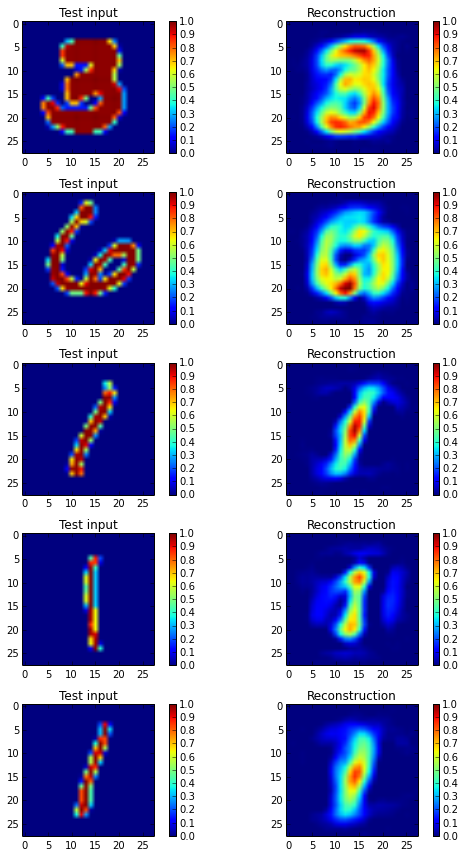

In [9]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Illustrating latent space

Next, we train a VAE with 2d latent space and illustrates how the encoder (the recognition network) encodes some of the labeled inputs (collapsing the Gaussian distribution in latent space to its mean). This gives us some insights into the structure of the learned manifold (latent space)

In [21]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=600, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture,labels_size=10, training_epochs=175)

3
Epoch: 0001 cost= 561.040332773 man_cost= 192.929554830 reconstr_cost= 356.519443129 latent_cost= 11.591335088 avg_reg_cost =  5.328403988 PLDA_eer =  35.415332498 Consine_eer =  39.606698414 PLDA_DCF =  (0.9999317764332547, 0.99970243013762228)
Epoch: 0006 cost= 399.509384454 man_cost= 71.919897147 reconstr_cost= 316.879294157 latent_cost= 10.710191156 avg_reg_cost =  5.717740191 PLDA_eer =  25.815537458 Consine_eer =  19.334124948 PLDA_DCF =  (1.0, 0.99991687532278417)
Epoch: 0011 cost= 379.733893695 man_cost= 62.151650612 reconstr_cost= 305.604371229 latent_cost= 11.977873263 avg_reg_cost =  6.114157691 PLDA_eer =  23.575565549 Consine_eer =  18.992408900 PLDA_DCF =  (0.99965036046039468, 0.99986867949205394)
Epoch: 0016 cost= 372.570892738 man_cost= 56.271491551 reconstr_cost= 303.542412828 latent_cost= 12.756986964 avg_reg_cost =  6.308678580 PLDA_eer =  21.745265681 Consine_eer =  18.241409329 PLDA_DCF =  (0.99934899394765941, 0.9998554125077872)
Epoch: 0021 cost= 367.230310725

<matplotlib.colorbar.Colorbar instance at 0x7f3bbdeb2200>

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


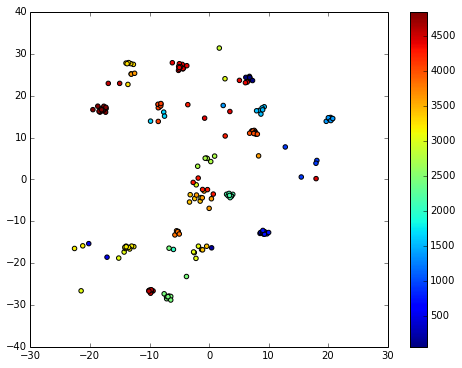

In [10]:
#x_sample, y_sample = mnist.test.next_batch(5000) 
x_sample, y_sample =  ivec14.train.next_batch(200)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
#plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample)
plt.colorbar()

An other way of getting insights into the latent space is to use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated:

In [12]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        z_mu = np.tile(z_mu,[500,1])
        x_mean = vae_2d.generate(z_mu)
        
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()

ValueError: total size of new array must be unchanged